# Introduction

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

In [3]:
data_path = Path("data//cleaned_tv_data.csv")
dtypes = {
    "no_of_ratings" : "Int64",
    "discount_price" : "Int64",
    "actual_price" : "Int64"
}
df = pd.read_csv(data_path, dtype=dtypes, index_col=0)
df.head()

,name,ratings,no_of_ratings,discount_price,actual_price,brand,size,color,resolution,type
0,Samsung 80 cm (32 Inches) Wondertainment Serie...,4.2,8877,12990,22900,SAMSUNG,32.0,BLACK,HD,Smart TV
1,MI 80 cm (32 inches) 5A Series HD Ready Smart ...,4.2,34286,13999,24999,MI,32.0,BLACK,HD,Smart TV
2,Redmi 80 cm (32 inches) Android 11 Series HD R...,4.2,47642,13999,24999,REDMI,32.0,BLACK,HD,Smart TV
3,OnePlus 138 cm (55 inches) Y Series 4K Ultra H...,4.2,8290,38999,49999,ONEPLUS,55.0,BLACK,4K,Smart TV
4,OnePlus 80 cm (32 inches) Y Series HD Ready LE...,4.2,36800,14999,19999,ONEPLUS,32.0,BLACK,HD,Smart TV


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1003 entries, 0 to 1102
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1003 non-null   object 
 1   ratings         538 non-null    float64
 2   no_of_ratings   538 non-null    Int64  
 3   discount_price  623 non-null    Int64  
 4   actual_price    645 non-null    Int64  
 5   brand           1003 non-null   object 
 6   size            969 non-null    float64
 7   color           635 non-null    object 
 8   resolution      791 non-null    object 
 9   type            996 non-null    object 
dtypes: Int64(3), float64(2), object(5)
memory usage: 89.1+ KB


# Price Prediction

## Preprocessing

### Drop na of actual price

In [5]:
price_df = df.copy(deep=True)
price_df = price_df[price_df["actual_price"].notna()]
print(price_df.shape)
price_df.head()

(645, 10)


,name,ratings,no_of_ratings,discount_price,actual_price,brand,size,color,resolution,type
0,Samsung 80 cm (32 Inches) Wondertainment Serie...,4.2,8877,12990,22900,SAMSUNG,32.0,BLACK,HD,Smart TV
1,MI 80 cm (32 inches) 5A Series HD Ready Smart ...,4.2,34286,13999,24999,MI,32.0,BLACK,HD,Smart TV
2,Redmi 80 cm (32 inches) Android 11 Series HD R...,4.2,47642,13999,24999,REDMI,32.0,BLACK,HD,Smart TV
3,OnePlus 138 cm (55 inches) Y Series 4K Ultra H...,4.2,8290,38999,49999,ONEPLUS,55.0,BLACK,4K,Smart TV
4,OnePlus 80 cm (32 inches) Y Series HD Ready LE...,4.2,36800,14999,19999,ONEPLUS,32.0,BLACK,HD,Smart TV


In [7]:
features = "brand,size,color,resolution,type".split(",")
target = "actual_price"

### Remove price outliers using IQR method

In [9]:
# Calculate Q1, Q3, and IQR
Q1 = price_df['actual_price'].quantile(0.25)  # First quartile (25th percentile)
Q3 = price_df['actual_price'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
price_df = price_df[(price_df['actual_price'] >= lower_bound) & (price_df['actual_price'] <= upper_bound)]

In [10]:
price_df.shape

(585, 10)

In [11]:
price_df = price_df[features + [target]]

### Impute nans, for size -> using knn imputer, for categorical ones, using mode

In [12]:
size_imputer = KNNImputer(n_neighbors=5)

price_df["size"] = size_imputer.fit_transform(price_df["size"].values.reshape(-1,1)).flatten()
price_df["color"] = price_df["color"].fillna(price_df["color"].mode().values[0])
price_df["resolution"] = price_df["resolution"].fillna(price_df["resolution"].mode().values[0])
price_df["type"] = price_df["type"].fillna(price_df["type"].mode().values[0])


### Feaure Visualization

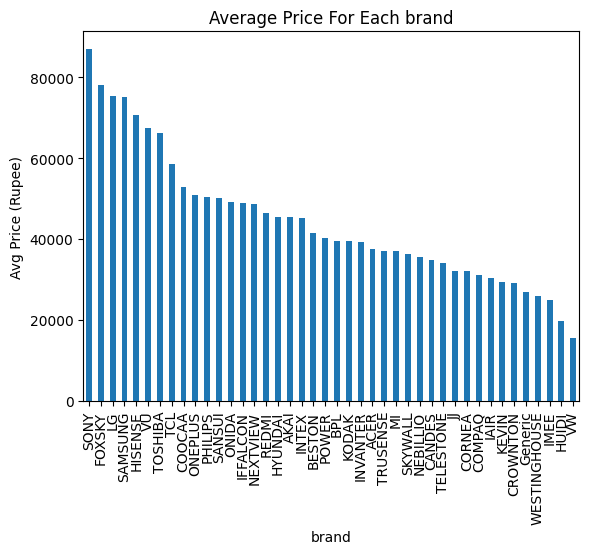

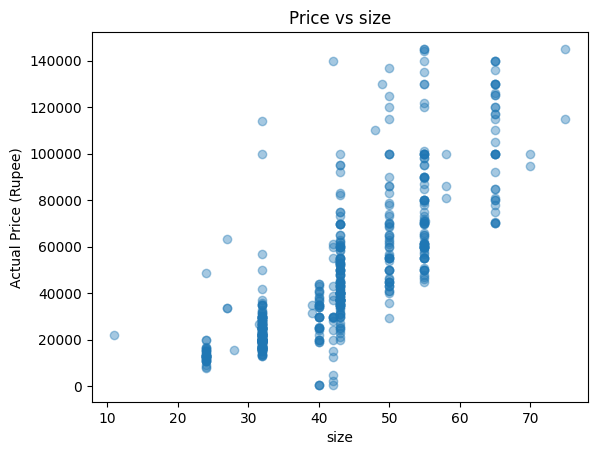

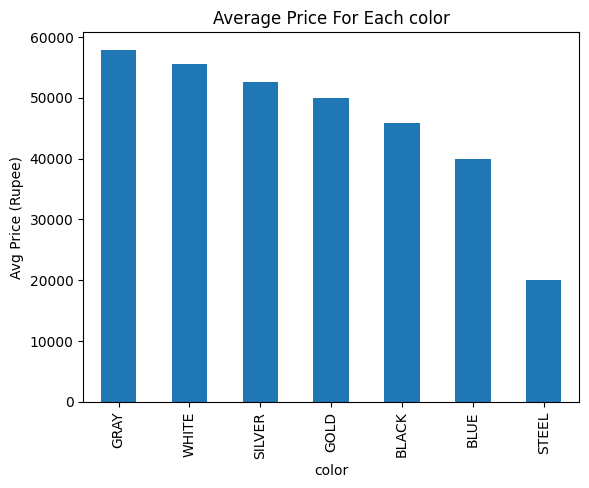

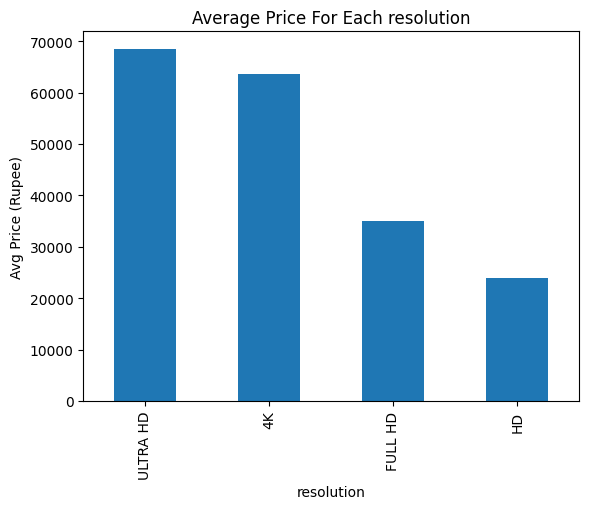

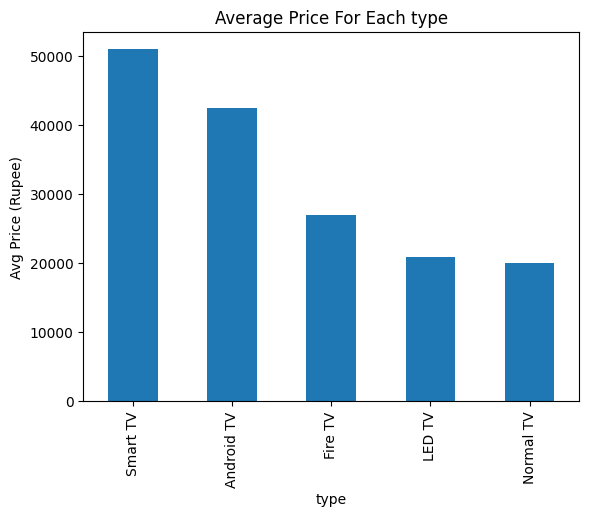

In [13]:
for col in price_df.columns:
    if col == target:
        continue
    plt.figure()
    if price_df[col].dtype == "object":
        title = f"Average Price For Each {col}"
        price_df.groupby(col)[target].mean().sort_values(ascending=False).plot(kind="bar")
        plt.title(title)
        plt.ylabel("Avg Price (Rupee)")
    else:
        title = f"Price vs {col}"
        plt.title(title)
        plt.scatter(price_df[col], price_df[target], alpha=0.4)
        plt.xlabel(col)
        plt.ylabel("Actual Price (Rupee)")

In [14]:
price_df.head()

,brand,size,color,resolution,type,actual_price
0,SAMSUNG,32.0,BLACK,HD,Smart TV,22900
1,MI,32.0,BLACK,HD,Smart TV,24999
2,REDMI,32.0,BLACK,HD,Smart TV,24999
3,ONEPLUS,55.0,BLACK,4K,Smart TV,49999
4,ONEPLUS,32.0,BLACK,HD,Smart TV,19999


## Modeling

In [72]:
# Separate features (X) and target (y)
X = price_df.drop('actual_price', axis=1)
y = price_df['actual_price']

# Define categorical and numerical columns
categorical_cols = ['brand', 'color', 'resolution', 'type']
numerical_cols = ['size']

# Preprocessing pipeline
# Step 1: One-Hot Encoding for categorical columns
# Step 2: Scaling for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

# Create a pipeline with preprocessing and random forest
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define hyperparameter grid for RandomizedSearchCV
param_dist = {
    'regressor__n_estimators': randint(50, 200),  # Number of trees
    'regressor__max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'regressor__min_samples_split': randint(2, 10),  # Minimum samples to split a node
    'regressor__min_samples_leaf': randint(1, 10),  # Minimum samples at a leaf node
    'regressor__bootstrap': [True, False]  # Whether to use bootstrap sampling
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=3,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Metric to evaluate
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)


In [73]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['brand',
                                                                                'color',
                                                                                'resolution',
                                                                                'type']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['size'])])),
                                             ('regressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__bootstrap': [True, False...
                                        'regressor__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DC6998FA90>,
                                        'regressor__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DC6998C510>,
                                        'regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DC6AC79F50>},
                   random_state=42, scoring='neg_mean_squared_error')

In [75]:
# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'regressor__bootstrap': True, 'regressor__max_depth': 30, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 185}


## Results

In [76]:
# Predict on the test set using the best model
y_pred = random_search.best_estimator_.predict(X_test)

In [83]:


# Optionally, check the model's score (R^2)
# print("\nModel Score (R^2):", random_search.score(X_test, y_test.values))
print("MAE", mean_absolute_error(y_pred, y_test))
print("MSE", mean_squared_error(y_pred, y_test))
print("RMSE", root_mean_squared_error(y_pred, y_test))
print("MAPE", mean_absolute_percentage_error(y_pred, y_test)*100)

MAE 8357.955326547599
MSE 164297316.78706676
RMSE 12817.851488727225
MAPE 19.20298344489052
